In [1]:
!git clone https://github.com/NCTU-VRDL/tensorflow2_yolov3.git


Cloning into 'tensorflow2_yolov3'...
remote: Enumerating objects: 141, done.
remote: Counting objects: 100% (141/141), done.
remote: Compressing objects: 100% (130/130), done.
remote: Total 141 (delta 74), reused 9 (delta 6), pack-reused 0
Receiving objects: 100% (141/141), 2.15 MiB | 7.01 MiB/s, done.
Resolving deltas: 100% (74/74), done.


In [2]:
%cd tensorflow2_yolov3

/content/tensorflow2_yolov3


In [3]:
!wget https://pjreddie.com/media/files/yolov3.weights

--2021-04-28 15:25:28--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  20.9MB/s    in 12s     

2021-04-28 15:25:41 (19.4 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



## YOLO-V3 架構圖
![alt text](https://gitee.com/yunyang1994/BlogSource/raw/master/hexo/source/images/YOLOv3/levio.png)

In [4]:
import cv2
import numpy as np
import core.utils as utils
import tensorflow as tf
from core.yolov3 import *
from PIL import Image
tf.keras.backend.clear_session()

input_size   = 416
image_path   = "./docs/kite.jpg"

input_layer  = tf.keras.layers.Input([input_size, input_size, 3])
feature_maps = YOLOv3(input_layer)

original_image = cv2.imread(image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
original_image_size = original_image.shape[:2]

image_data = utils.image_preporcess(np.copy(original_image), [input_size, input_size])
image_data = image_data[np.newaxis, ...].astype(np.float32)

bbox_tensors = []
for i, fm in enumerate(feature_maps):
    bbox_tensor = decode(fm, i)
    bbox_tensors.append(bbox_tensor)

model = tf.keras.Model(input_layer, bbox_tensors)
utils.load_weights(model, "./yolov3.weights")

In [5]:
feature_maps[2].shape

TensorShape([None, 13, 13, 255])

In [6]:
pred_bbox = model.predict(image_data)
pred_bbox = [tf.reshape(x, (-1, tf.shape(x)[-1])) for x in pred_bbox]
pred_bbox = tf.concat(pred_bbox, axis=0)
bboxes = utils.postprocess_boxes(pred_bbox, original_image_size, input_size, 0.3)
bboxes = utils.nms(bboxes, 0.45, method='nms')

image = utils.draw_bbox(original_image, bboxes)
image = Image.fromarray(image)

In [7]:
pred_bbox = model.predict(image_data)

In [17]:
image_data = utils.image_preporcess(np.copy(original_image), [input_size, input_size])
image_data = image_data[np.newaxis, ...].astype(np.float32)

In [19]:
??utils.image_preporcess

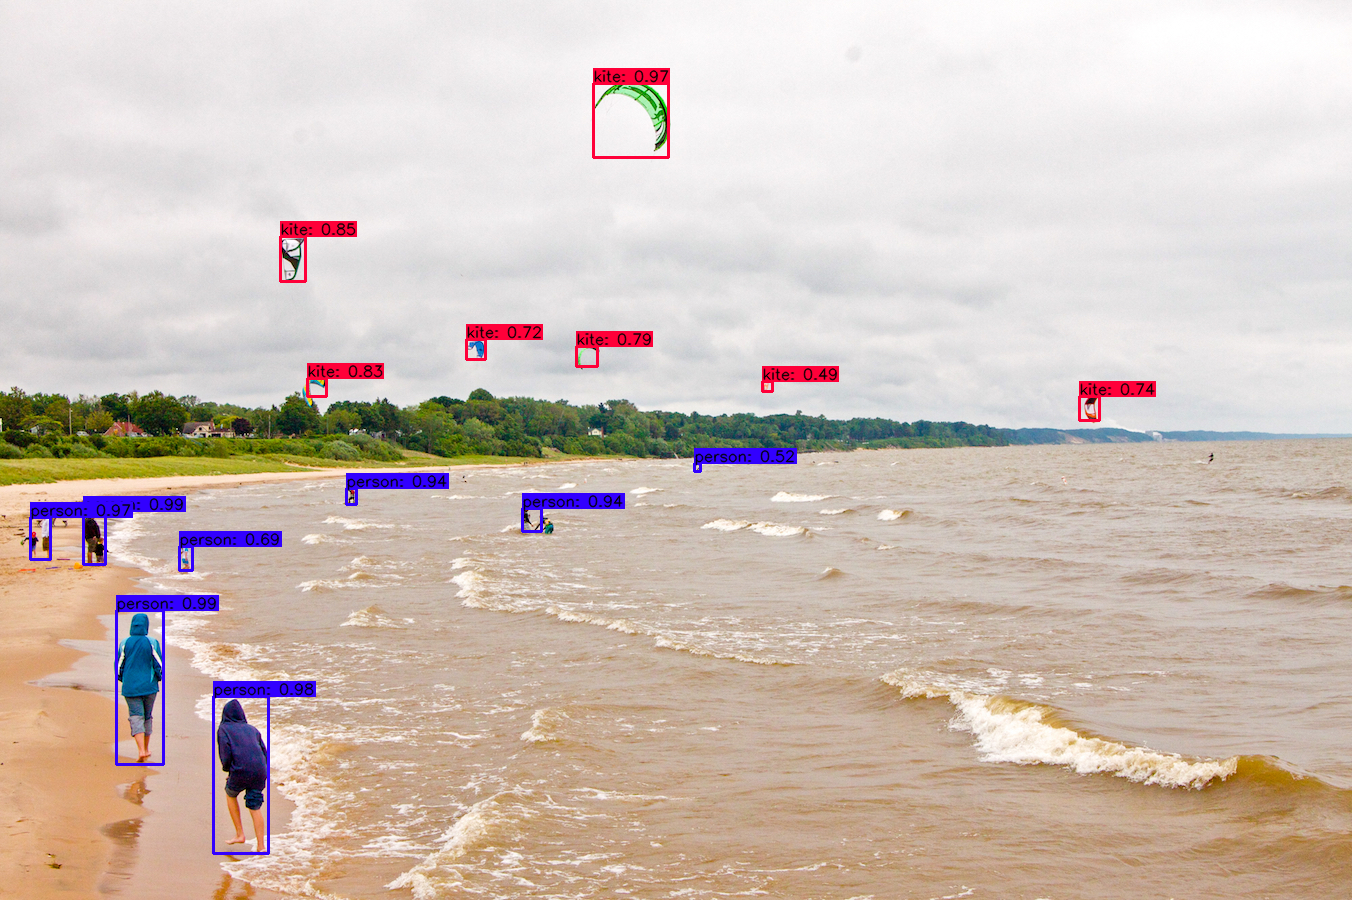

In [10]:
image

In [11]:
pred_bbox[1][0,21,4,2,6:]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan], dtype=float32)

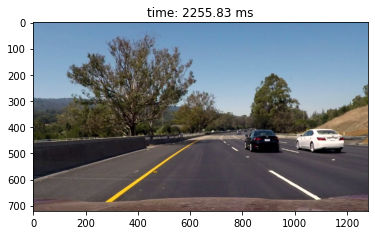

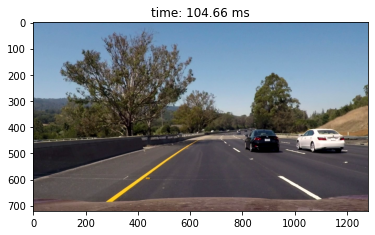

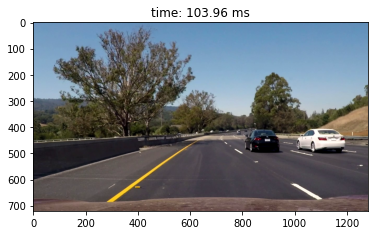

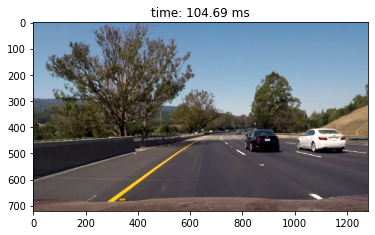

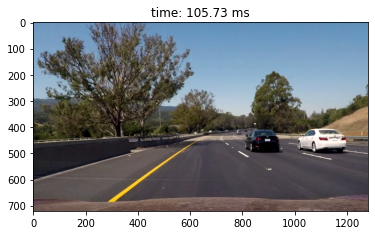

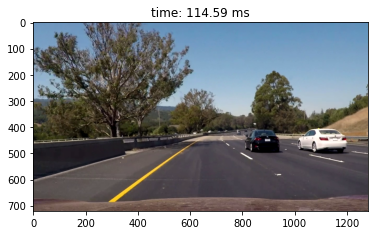

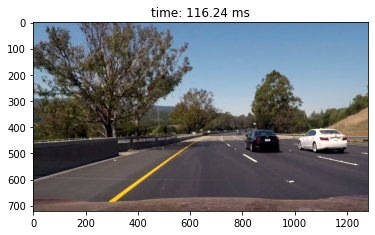

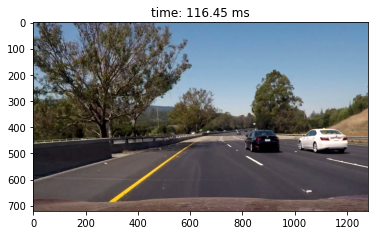

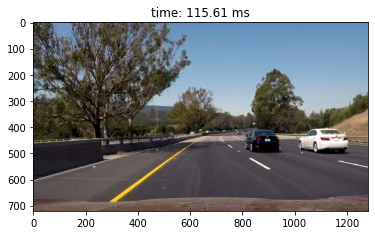

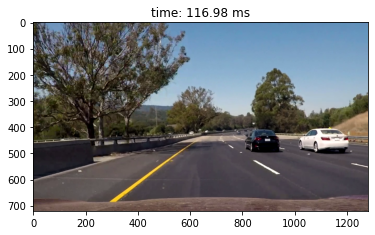

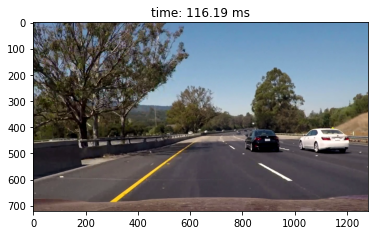

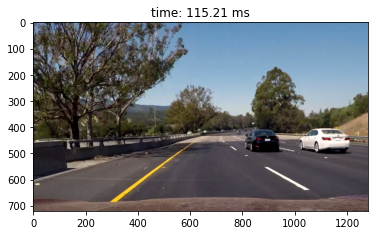

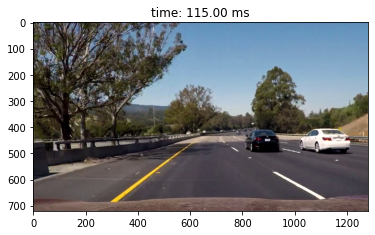

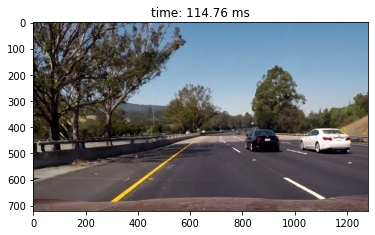

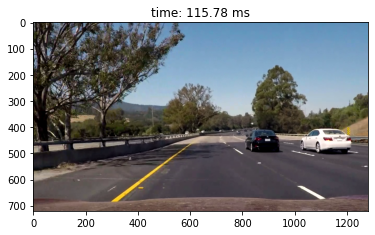

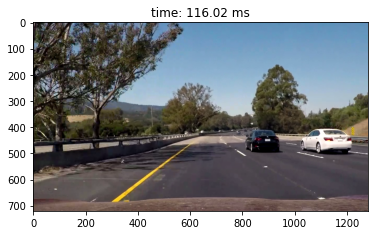

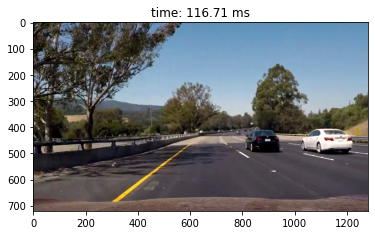

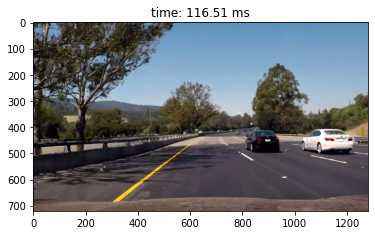

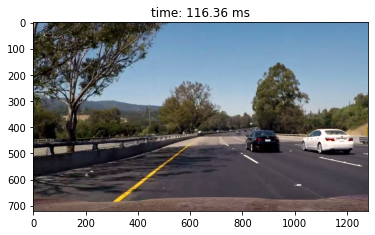

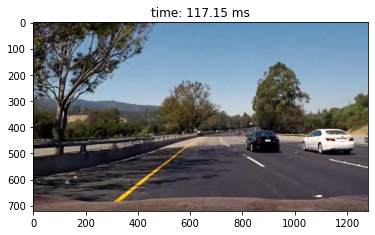

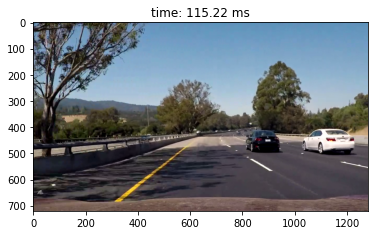

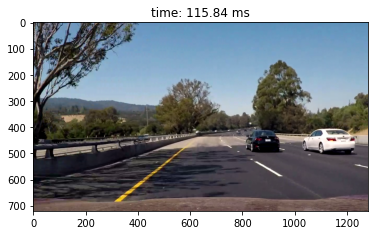

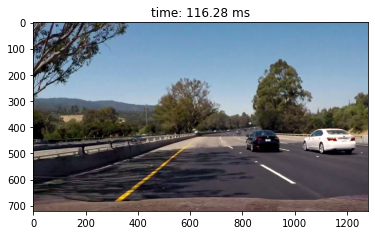

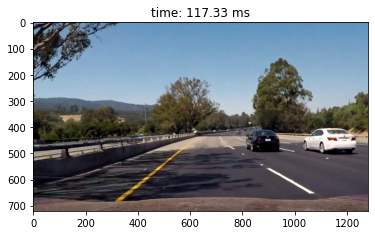

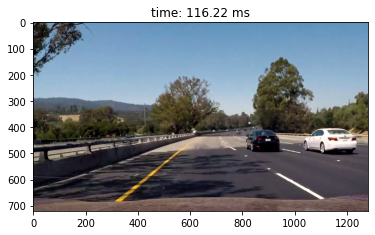

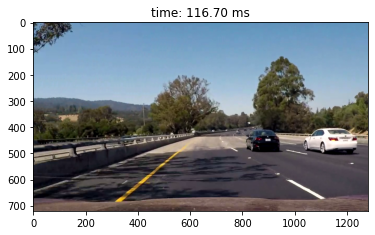

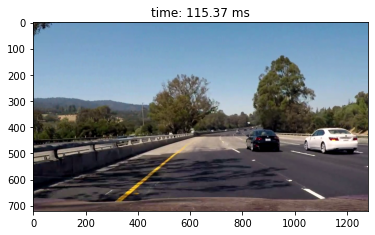

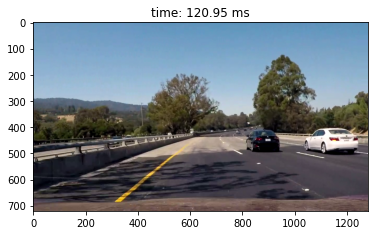

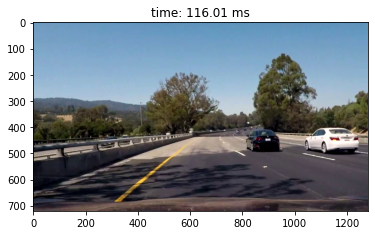

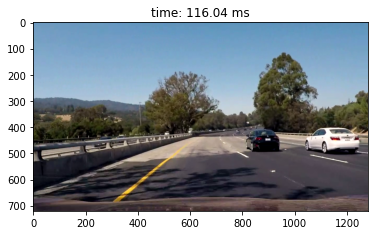

In [12]:
import time
import matplotlib.pyplot as plt

video_path      = "./docs/road.mp4"

num_classes     = 80
input_size      = 416

vid = cv2.VideoCapture(video_path)
for _ in range(30):
    return_value, frame = vid.read()
    if return_value:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    else:
        raise ValueError("No image!")
    frame_size = frame.shape[:2]
    image_data = utils.image_preporcess(np.copy(frame), [input_size, input_size])
    image_data = image_data[np.newaxis, ...].astype(np.float32)

    prev_time = time.time()
    pred_bbox = model.predict_on_batch(image_data)
    curr_time = time.time()
    exec_time = curr_time - prev_time

    pred_bbox = [tf.reshape(x, (-1, tf.shape(x)[-1])) for x in pred_bbox]
    pred_bbox = tf.concat(pred_bbox, axis=0)
    bboxes = utils.postprocess_boxes(pred_bbox, frame_size, input_size, 0.3)
    bboxes = utils.nms(bboxes, 0.45, method='nms')
    image = utils.draw_bbox(frame, bboxes)

    result = np.asarray(image)
    info = "time: %.2f ms" %(1000*exec_time)
    plt.title(info)
    plt.imshow(result)
    plt.show()